<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/Multivariate_Single_Step_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

import sys
import seaborn as sns
import pandas as pd
from numpy import zeros, newaxis
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, \
    Flatten, Activation

## 1. Data Acquisition

In [2]:
# Read Csv
file = r"/content/PG.csv"
df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
plt.style.use('seaborn')

#### 1.1 Info Dataframe

In [3]:
df.shape[0]

13145

In [4]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,1.710938,1.722656,1.708984,1.718750,0.399508,832000
1970-01-05,1.718750,1.730469,1.708984,1.726563,0.401324,518400
1970-01-06,1.722656,1.722656,1.707031,1.718750,0.399508,480000
1970-01-07,1.722656,1.750000,1.722656,1.746094,0.405864,710400
1970-01-08,1.746094,1.773438,1.742188,1.765625,0.410404,531200


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,13145.000000,13145.000000,13145.000000,13145.000000,13145.000000,1.314500e+04
mean,36.142272,36.438890,35.866873,36.167073,26.801095,5.719207e+06
std,36.878137,37.155614,36.631969,36.899929,33.636763,5.268075e+06
min,1.273438,1.289063,1.253906,1.257813,0.295987,5.120000e+04
25%,3.304688,3.335938,3.281250,3.304688,1.119417,2.204800e+06
50%,21.000000,21.187500,20.812500,21.031250,11.034281,4.850600e+06
75%,62.540001,63.040001,62.119999,62.630001,42.619820,7.772900e+06
max,164.399994,165.350006,163.399994,164.210007,164.139999,1.372872e+08


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13145 entries, 1970-01-02 to 2022-02-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       13145 non-null  float64
 1   High       13145 non-null  float64
 2   Low        13145 non-null  float64
 3   Close      13145 non-null  float64
 4   Adj Close  13145 non-null  float64
 5   Volume     13145 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 718.9 KB


## 2. Data Visualization

##### 2.1 Time series visualization

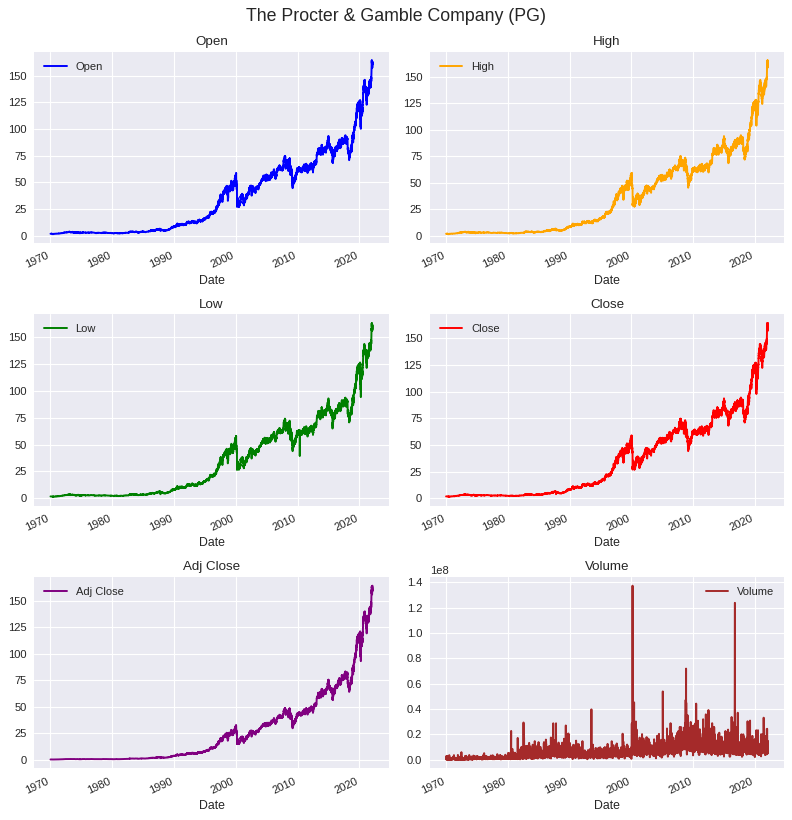

In [7]:
plt.style.use('seaborn')

titles = [
    "Open",
    "High",
    "Low",
    "Close",
    "Adj Close",
    "Volume",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
]


def show_raw_visualization(data):
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(titles)):
        c = colors[i % (len(colors))]
        t_data = data[titles[i]]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(titles[i]),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    fig.suptitle('The Procter & Gamble Company (PG)', fontsize=16, y=1.02)
    # plt.savefig('Timeseries_PG.png', dpi=1200)


show_raw_visualization(df)

##### 2.2 Correlation Heatmap

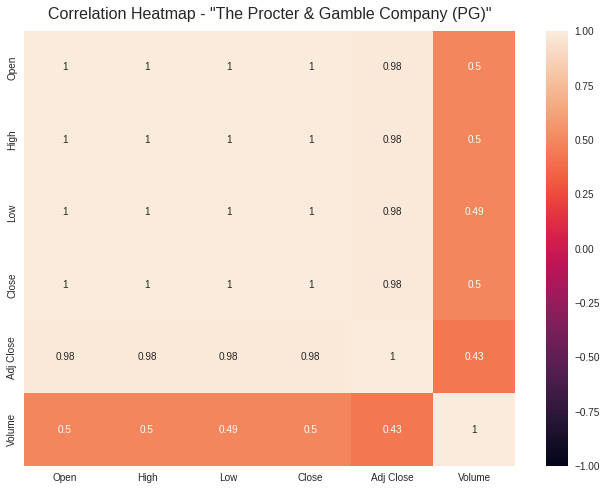

In [8]:
# Increase the size of the heatmap.
plt.figure(figsize=(11, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title). Set
# the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the
# correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap - "The Procter & Gamble Company (PG)"', fontdict={'fontsize': 16}, pad=12)
# plt.savefig('Heatmap_PG.png', dpi=1200)
plt.show()

##### 2.3 Histogram

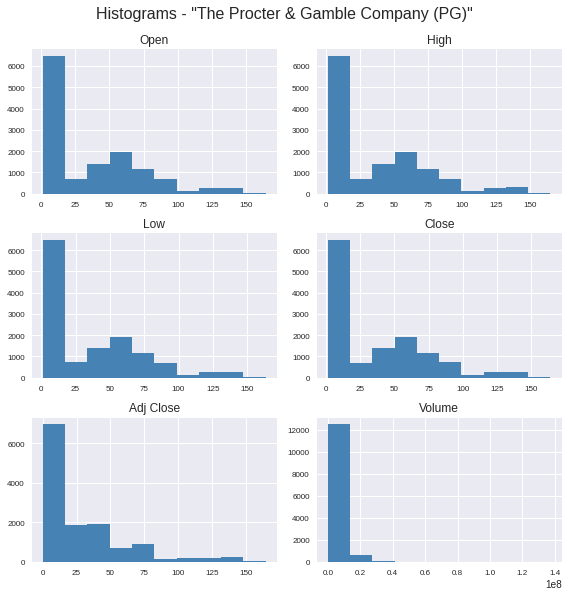

In [9]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(8, 8))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(bins=10, ax=ax, color='steelblue', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=True)
        ax.set_title(var_name)
    plt.tight_layout()
    fig.suptitle('Histograms - "The Procter & Gamble Company (PG)"', fontsize=16, y=1.03)
    # plt.savefig('Histograms_PG.png', dpi=1200)
    plt.show()


draw_histograms(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2)

##### 2.4 BoxPlot

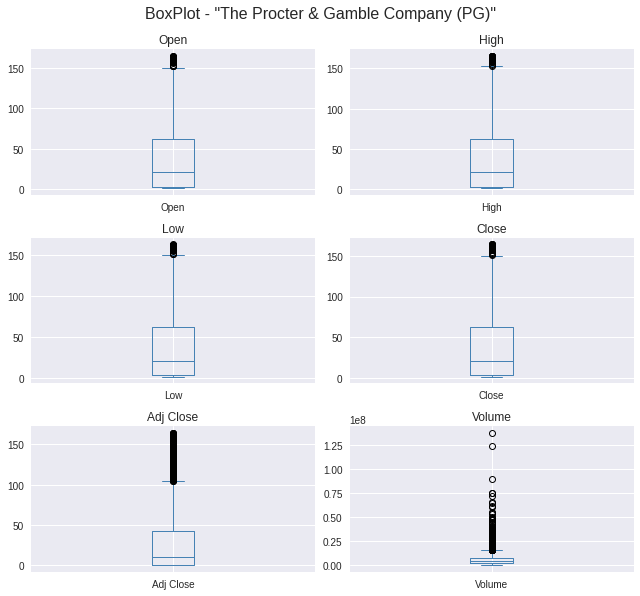

In [10]:
def draw_boxplot(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(9, 8))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].plot.box(ax=ax, color='steelblue', grid=True)
        ax.set_title(var_name)
    plt.tight_layout()
    fig.suptitle('BoxPlot - "The Procter & Gamble Company (PG)"', fontsize=16, y=1.03)
    # plt.savefig('BoxPlot_PG.png', format='png', dpi=1200)
    plt.show()


draw_boxplot(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2)

## 3. Data prepocessing

#### 3.1 Data Cleaning

In [11]:
# Check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There aren't missing value

In [12]:
# Replace missing values by interpolation
def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

# replace_missing(df['Open'])
# ....

In [13]:
# Detect and remove outliers with IQR
def detect_remove_outliers(df, column):
    # IQR
    Q1 = np.percentile(df[f'{column}'], 25, interpolation='midpoint')
    Q3 = np.percentile(df[f'{column}'], 75, interpolation='midpoint')
    IQR = Q3 - Q1

    # Above Upper bound
    upper = df[f'{column}'] >= (Q3 + 1.5 * IQR)
    # print("Upper bound:", upper)
    print("Upper bound outliers:", f'{column}', np.where(upper))

    # Below Lower bound
    lower = df[f'{column}'] <= (Q1 - 1.5 * IQR)
    # print("Lower bound:", lower)
    print("Lower bound:", f'{column}', np.where(lower))

    # Removing the Outliers 
    # df.drop(upper, inplace = True)
    # df.drop(lower, inplace = True)
    
    # print("New Shape: ", df.shape)
    return

# There may be potential outliers in the Volume column, but they won't be considered outliers because
# a large volume of transactions is related to a change in the closing price
# For the other columns it was previously verified graphically with the boxplot that there aren't outliers.
# Also mathematically, with the IQR method, the same result is gotten.

titles = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

for i in titles:
       detect_remove_outliers(df, f'{i}')

Upper bound outliers: Open (array([13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108,
       13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117,
       13118, 13119, 13120, 13121, 13122, 13123, 13124, 13125, 13126,
       13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135,
       13136, 13137, 13138, 13139, 13140, 13141, 13142, 13143, 13144]),)
Lower bound: Open (array([], dtype=int64),)
Upper bound outliers: High (array([13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109,
       13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118,
       13119, 13120, 13121, 13122, 13123, 13124, 13125, 13126, 13127,
       13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135, 13136,
       13137, 13138, 13139, 13140, 13141, 13142, 13143, 13144]),)
Lower bound: High (array([], dtype=int64),)
Upper bound outliers: Low (array([13100, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109,
       13110, 13111, 13112, 13113, 13114, 13115, 13116, 1311

*   It seems that these are not outliers. They are a part of the trends of the timeseries

#### 3.2 Data Splitting

In [14]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset it was decided to use a manual
train_size = 0.8
valid_size = 0.1

train_index = int(len(df) * train_size)

df_train = df[0:train_index]
df_rem = df[train_index:]

valid_index = int(len(df) * valid_size)

df_valid = df[train_index:train_index + valid_index]
df_test = df[train_index + valid_index:]
test_index = df_test.shape[0]

# All the features have been considered in the training set
# In the test set has only been included Close Price
X_train, y_train = df_train, df_train[['Close']]
X_valid, y_valid = df_valid, df_valid[['Close']]
X_test, y_test = df_test, df_test[['Close']]

print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)


X_train.shape: (10516, 6) y_train.shape: (10516, 1)
X_valid.shape: (1314, 6) y_valid.shape: (1314, 1)
X_test.shape: (1315, 6) y_test.shape: (1315, 1)


#### 3.3 Data Transformation

In [15]:
# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

'''
# Other transformers
# StandardScaler
st_scaler = StandardScaler()
X_train = st_scaler.fit_transform(X_train)
X_test = st_scaler.transform(X_test)

# PowerTransformer
pt = PowerTransformer()
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)
'''
# Convert y sets to numpy array
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()
y_test = y_test.to_numpy()


#### 3.4 Set "***Window size***" and **step_ahead** to predict

In [16]:
# Create a 3D input
def create_dataset(X, y, lag=1, n_ahead=1):
    Xs, ys = [], []
    for i in range(len(X) - lag - n_ahead):
        Xs.append(X[i:(i + lag)])
        ys.append(y[(i + lag):(i + lag + n_ahead)])
    return np.array(Xs), np.array(ys)


# Choose lag window
time_steps = 20
# Choose 1 for a single step prediction or 2, 3, ..., n for a multi step prediction
step_ahead = 1

X_train, y_train = create_dataset(X_train, y_train, time_steps, step_ahead)
X_test, y_test = create_dataset(X_test, y_test, time_steps, step_ahead)
X_valid, y_valid = create_dataset(X_valid, y_valid, time_steps, step_ahead)


print('All shapes are: (batch, time, features)')
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

All shapes are: (batch, time, features)
X_train.shape: (10495, 20, 6) y_train.shape: (10495, 1, 1)
X_valid.shape: (1293, 20, 6) y_valid.shape: (1293, 1, 1)
X_test.shape: (1294, 20, 6) y_test.shape: (1294, 1, 1)


## 4. Model Choice and Learning

In [17]:
# Create Simple RNN model
def create_rnn():
    model = Sequential()
    model.add(SimpleRNN(35, return_sequences=True,
                        input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(SimpleRNN(20, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(5, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(2, activation='relu'))
    model.add(Dropout(0))
    model.add(Dense(units=y_train.shape[1], activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))  # Default_lr = 0.001
    model.summary()

    return model


# Create GRU model
def create_gru():
    model = Sequential()
    model.add(GRU(32, return_sequences=True,
                  input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(GRU(32, return_sequences=True, activation='relu'))
    model.add(GRU(32, return_sequences=True, activation='relu'))
    model.add(GRU(32, activation='relu'))
    model.add(Dropout(0))
    model.add(Dense(units=y_train.shape[1], activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))  # Default_lr = 0.001
    model.summary()

    return model


# Create GRU model
def create_lstm():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64, return_sequences=True, activation='tanh'))
    model.add(LSTM(64, return_sequences=False, activation='tanh'))
    model.add(Dropout(0))
    model.add(Dense(units=y_train.shape[1]))
    model.add(Activation('linear'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))  # Default_lr = 0.001
    model.summary()

    return model


def create_cnn1d():
    # model.add(tf.keras.layers.Dense(1))
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(0))
    model.add(Conv1D(filters=11, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(0))
    model.add(Conv1D(filters=21, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(0))
    model.add(Flatten())
    model.add(Dense(units=y_train.shape[1]))
    model.add(Activation('linear'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))  # Default_lr = 0.001
    model.summary()

    return model


# GRU and LSTM
model_rnn = create_rnn()
# model_gru = create_gru()
# model_lstm = create_lstm()
# model_cnn_1d = create_cnn_1d()


def fit_rnn(model):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train,
                        epochs=250,
                        batch_size=350,
                        validation_data=[X_valid, y_valid],
                        callbacks=[early_stop])
    return history


def fit_gru(model):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train,
                        epochs=35,
                        batch_size=60,
                        validation_data=[X_valid, y_valid],
                        callbacks=[early_stop])
    return history


def fit_lstm(model):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        epochs=200,
                        batch_size=40,
                        validation_data=[X_valid, y_valid],
                        callbacks=[early_stop])
    return history


def fit_cnn_1d(model):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=100,
                        validation_data=[X_valid, y_valid],
                        callbacks=[early_stop])
    return history


history_rnn = fit_rnn(model_rnn)
# history_gru = fit_gru(model_gru)
# history_lstm = fit_lstm(model_lstm)
# history_cnn_1d = fit_cnn_1d(model_cnn_1d)


y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])


'''
checkpoint_filepath = "train_ckpt/cp.ckpt"

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=checkpoint_filepath,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)

# model.load_weights(checkpoint_filepath)
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 35)            1470      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 20)            1120      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 5)             130       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 2)                 16        
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 2,739
Trainable params: 2,739
Non-trainabl

'\ncheckpoint_filepath = "train_ckpt/cp.ckpt"\n\nmodelckpt_callback = keras.callbacks.ModelCheckpoint(\n    monitor="val_loss",\n    filepath=checkpoint_filepath,\n    verbose=0,\n    save_weights_only=True,\n    save_best_only=True,\n)\n\n# model.load_weights(checkpoint_filepath)\n'

In [18]:
def plot_model_summary(model, model_name):
    plot_model(model, to_file='model_summary_' + model_name + '.png', show_shapes=True)


plot_model_summary(model_rnn, 'rnn')
# plot_model_summary(model_gru, 'gru')
# plot_model_summary(model_lstm, 'lstm')
# plot_model_summary(model_cnn_1d, 'cnn1d')

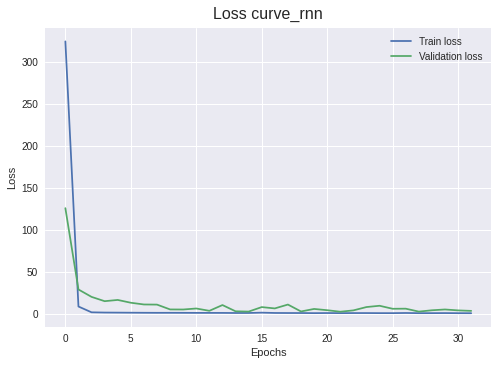

In [19]:
# LOSS CURVE
# Plot train loss and validation loss

def plot_loss(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss curve_' + model_name, fontsize=16, y=1.01)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    # plt.savefig('Loss curve_' + model name + '.png', dpi=1200)
    plt.show()


plot_loss(history_rnn, 'rnn')
# plot_loss(history_gru, 'gru')
# plot_loss(history_lstm, 'lstm')
# plot_loss(history_cnn_1d, 'cnn1d')

(1294, 20, 6)


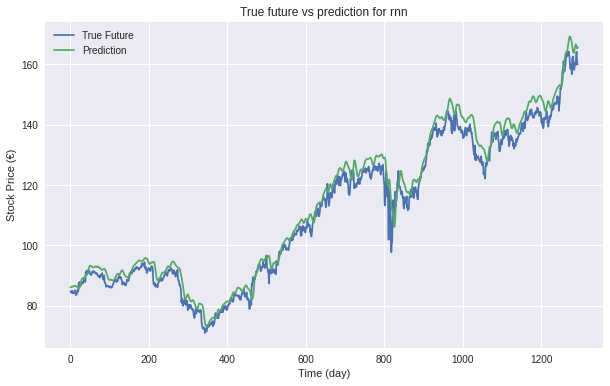

In [20]:
# Make prediction
def prediction(model):
    print(X_test.shape)
    prediction = model.predict(X_test)
    return prediction


prediction_rnn = prediction(model_rnn)
# prediction_gru = prediction(model_gru)
# prediction_lstm = prediction(model_lstm)
# prediction_cnn1d = prediction(model_cnn_1d)


def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Stock Price (€)')
    # plt.savefig('Prediction_Evaluation_plot_' + model_name + '.png', dpi=1200)
    plt.show()


plot_future(prediction_rnn, 'rnn', y_test)
# plot_future(prediction_gru, 'gru', y_test)
# plot_future(prediction_lstm, 'lstm', y_test)
# plot_future(prediction_cnn1d, 'cnn1d', y_test)




**The code has been run to show that it works. The best performance of the algorithms are shown in ....**

## 5. Model Evaluation

In [21]:
# Define a function to calculate MAE and RSME
def evaluate_prediction(predicted, actual, model_name):
    if step_ahead == 1:
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Root Mean Square Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return
    else:
        titles = ["RMSE", "MAE", "R^2"]
        # calculate an RMSE score for each day
        # calculate mse
        rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='raw_values'))
        mae = mean_absolute_error(predicted, actual, multioutput='raw_values')
        r2 = r2_score(predicted, actual, multioutput='raw_values')
        df_scores = pd.DataFrame(list(zip(rmse, mae, r2)), columns=[f'{x}' for x in titles])
        df_scores.index += 1

        colors = plt.rcParams["axes.prop_cycle"]()
        a = 1  # number of rows
        b = 3  # number of columns
        c = 1  # initialize plot counter
        fig = plt.figure(figsize=(15, 6))
        for i in titles:
            plt.subplot(a, b, c)
            plt.title(f'{i}')
            next_colour = next(colors)["color"]
            df_scores[f'{i}'].plot(marker='o', color=next_colour)
            plt.xticks((range(0, df_scores.shape[0] + 1)))
            plt.legend(loc='upper left')
            plt.xlabel('Forecast Range (Day)')
            plt.ylabel(f'{i}')
            c = c + 1

        plt.subplots_adjust(.5)
        fig.suptitle("Evaluation of performances' trend in the multi step forecasted range", fontsize=16, y=1)
        plt.tight_layout()
        # plt.savefig('EvaluationMultiplePrediction_PG.png', dpi=1200)
        plt.show()

        # calculate overall RMSE
        overall_rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='uniform_average'))
        overall_mae = mean_absolute_error(predicted, actual, multioutput='uniform_average')
        overall_r2 = r2_score(predicted, actual, multioutput='uniform_average')
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(overall_r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(overall_mae))
        print('Root Mean Square Error: {:.4f}'.format(overall_rmse))
        print('')
        return


evaluate_prediction(prediction_rnn, y_test, 'rnn')
# evaluate_prediction(prediction_gru, y_test, 'gru')
# evaluate_prediction(prediction_lstm, y_test, 'lstm')
# evaluate_prediction(prediction_cnn_1d, y_test, 'cnn1d')


rnn performance:
R^2: 97.3860 %
Mean Absolute Error: 3.1143
Root Mean Square Error: 3.8763
Max_error: 19.3268



In [22]:
def save_model(model, model_name):
    model.save('./' + model_name + 'model')
    return


save_model(model_rnn, 'rnn')
# save_model(model_gru, 'gru')
# save_model(model_lstm, 'lstm')
# save_model(model_cnn1d, 'cnn1d')


# Code to reload model and verify that the operation of saving went well
# loaded_model = tf.keras.models.load_model('./best_model_simple_rnn')
# loaded_model.summary()
# assert np.allclose(model_simple_rnn.predict(X_test), loaded_model.predict(X_test))

INFO:tensorflow:Assets written to: ./rnn/assets
